In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from AFLPy.AFLData_Client import load_data, upload_data, metadata

Data

In [3]:
md = metadata(ID = "AFL")
afltables_player_stats = load_data(Dataset_Name='AFLTables_Player_Stats', ID = "AFL")
afl_team_positions = load_data(Dataset_Name='AFL_API_Team_Positions', ID = "AFL")
player_positions = afl_team_positions[['Player_ID', 'Match_ID', 'Position', 'Position_Sub_Group', 'Position_Group']]
chains = load_data(Dataset_Name='AFL_API_Match_Chains', ID = 'AFL')
shots = pd.read_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/predictions/shots_xs_catboost.csv")
shots['Year'] = shots['Match_ID'].apply(lambda x: int(x.split("_")[1]))
shots['Round'] = shots['Match_ID'].apply(lambda x: x.split("_")[2])

In [4]:
shots.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal,predicted_result,behind_probas,goal_probas,miss_probas,xscore,angle,angle_degrees,chain_duration,description_0,description_1,description_2,description_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,ground_kick,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3,Year,Round
0,CD_I990609,5,Brisbane,possGain,behind,1.0,50.0,Kick,ineffective,True,NaN,48.0,118.0,44.0,12.0,Sydney,Brisbane,right,141.0,160.0,Charlie Cameron,Brisbane,AFL_2024_F4_Sydney_Brisbane,charlie_cameron,behind,1,0,1,0,goal,0.326611,0.639306,0.034083,4.162447,0.321751,18.434949,68.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,37.947332,3.636199,8.246211,1440.0,36.0,12.0,0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0,2024,F4
1,CD_I294518,12,Brisbane,possGain,behind,1.0,270.0,Kick,ineffective,True,NaN,112.0,327.0,56.0,-33.0,Sydney,Brisbane,right,141.0,160.0,Joe Daniher,Brisbane,AFL_2024_F4_Sydney_Brisbane,joe_daniher,behind,1,0,1,0,goal,0.412004,0.453756,0.134240,3.134539,0.942000,53.972627,57.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,40.804412,3.708790,8.944272,1665.0,24.0,33.0,0,possGain,327.0,292.0,291.0,290.0,1,35.0,0.292973,16.786129,0.092823,5.318374,56.0,60.0,60.0,22.0,-33.0,-25.0,-25.0,-64.0,2024,F4
2,CD_I1006126,22,Sydney,throwIn,behind,1.0,550.0,Kick,ineffective,True,NaN,196.0,558.0,64.0,15.0,Sydney,Brisbane,right,141.0,160.0,James Rowbottom,Sydney,AFL_2024_F4_Sydney_Brisbane,james_rowbottom,behind,1,0,1,0,goal,0.389350,0.460539,0.150111,3.152583,0.753151,43.152390,8.0,Kick,Loose Ball Get,Gather,Contested Knock On,21.931712,3.087934,4.472136,481.0,16.0,15.0,0,throwIn,558.0,557.0,552.0,550.0,0,1.0,0.790042,45.266082,0.217521,12.463013,64.0,60.0,59.0,61.0,15.0,17.0,15.0,16.0,2024,F4
3,CD_I997100,24,Sydney,possGain,goal,1.0,576.0,Kick,effective,True,NaN,207.0,596.0,58.0,-21.0,Sydney,Brisbane,right,141.0,160.0,Will Hayward,Sydney,AFL_2024_F4_Sydney_Brisbane,will_hayward,goal,6,0,0,1,goal,0.350931,0.598992,0.050077,3.944881,0.762147,43.667780,20.0,Kick,Free Advantage,Free For,Kick Inside 50 Result,30.413813,3.414897,7.615773,925.0,22.0,21.0,0,possGain,596.0,595.0,594.0,589.0,1,1.0,0.507180,29.059288,0.153920,8.818975,58.0,55.0,62.0,62.0,-21.0,-28.0,-30.0,-30.0,2024,F4
4,CD_I996765,25,Sydney,centreBounce,goal,1.0,659.0,Kick,effective,True,NaN,218.0,677.0,51.0,28.0,Sydney,Brisbane,right,141.0,160.0,Tom Papley,Sydney,AFL_2024_F4_Sydney_Brisbane,tom_papley,goal,6,0,0,1,behind,0.467258,0.302938,0.229804,2.284884,0.767856,43.994914,18.0,Kick,Handball Received,Handball,Gather,40.311289,3.696632,10.000000,1625.0,29.0,28.0,0,centreBounce,677.0,675.0,673.0,673.0,0,2.0,0.363247,20.812538,0.114940,6.585559,51.0,45.0,48.0,50.0,28.0,20.0,19.0,19.0,2024,F4


Highest Players

In [5]:
def create_player_match_summary(shots, positions, percent_played):
    
    player_match_summary = shots.groupby(['Player_ID', 'Player', 'Team', 'Match_ID', 'Year']).agg(
        score = ('score', 'sum'),
        xscore = ('xscore', 'sum'),
        num_shots = ('score', 'size'),
        num_games = ('Match_ID', 'nunique')
    )
    player_match_summary = player_match_summary.reset_index().merge(positions, how = 'left', left_on=['Player_ID', 'Match_ID'], right_on=['Player_ID', 'Match_ID'])
    player_match_summary = player_match_summary.merge(percent_played[['Match_ID', 'Player_ID', 'Percent_Played']], how = 'left', left_on=['Player_ID', 'Match_ID'], right_on=['Player_ID', 'Match_ID'] )
    player_match_summary = player_match_summary.drop(columns=['Player_ID'])
    
    return player_match_summary
    

In [6]:
player_match_summary = create_player_match_summary(shots, player_positions, percent_played=afltables_player_stats[['Match_ID', 'Player_ID', 'Percent_Played']])
player_match_summary.head()

,Player,Team,Match_ID,Year,score,xscore,num_shots,num_games,Position,Position_Sub_Group,Position_Group,Percent_Played
0,Aaron Black,West Coast,AFL_2022_02_NorthMelbourne_WestCoast,2022,6,3.247522,2,1,Ruck Rover,Centre,Midfield,75.0
1,Aaron Cadman,Greater Western Sydney,AFL_2023_05_GreaterWesternSydney_Hawthorn,2023,6,4.367239,1,1,Interchange,Interchange,Interchange,62.0
2,Aaron Cadman,Greater Western Sydney,AFL_2023_06_GreaterWesternSydney_Brisbane,2023,6,4.403906,1,1,Interchange,Interchange,Interchange,63.0
3,Aaron Cadman,Greater Western Sydney,AFL_2023_07_Sydney_GreaterWesternSydney,2023,6,7.490939,3,1,Interchange,Interchange,Interchange,43.0
4,Aaron Cadman,Greater Western Sydney,AFL_2023_08_GreaterWesternSydney_WesternBulldogs,2023,6,1.841222,1,1,Interchange,Interchange,Interchange,50.0


In [7]:
def create_expected_score_summary(player_match_summary, group_cols, min_shots=50, min_games = 20, sort_by = 'xscore'):
    
    shots_groupby = player_match_summary.groupby(group_cols).agg(
        score = ('score', 'sum'),
        xscore = ('xscore', 'sum'),
        num_shots = ('num_shots', 'sum'),
        num_games = ('num_games', 'sum'),
        percent_played = ('Percent_Played', 'mean')
    )
    shots_groupby['score_per_shot'] = shots_groupby['score'] / shots_groupby['num_shots']
    shots_groupby['score_per_game'] = shots_groupby['score'] / shots_groupby['num_games']

    shots_groupby['xscore_per_shot'] = shots_groupby['xscore'] / shots_groupby['num_shots']
    shots_groupby['xscore_per_game'] = shots_groupby['xscore'] / shots_groupby['num_games']
    
    shots_groupby['shots_per_game'] = shots_groupby['num_shots'] / shots_groupby['num_games']
    
    shots_groupby['score_per_90pc'] = 90 * shots_groupby['score'] / shots_groupby['percent_played'] / shots_groupby['num_games']
    shots_groupby['xscore_per_90pc'] = 90 * shots_groupby['xscore'] / shots_groupby['percent_played'] / shots_groupby['num_games']
    shots_groupby['shots_per_90pc'] = 90 * shots_groupby['num_shots'] / shots_groupby['percent_played'] / shots_groupby['num_games']
    
    return shots_groupby[(shots_groupby['num_shots'] > min_shots) & (shots_groupby['num_games'] > min_games)].sort_values(sort_by, ascending=False)

In [8]:
player_summary = create_expected_score_summary(player_match_summary, group_cols='Player')

In [9]:
player_summary.head()

,score,xscore,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc
Player,,,,,,,,,,,,,
Charlie Cameron,1402,1406.824470,386,100,84.171717,3.632124,14.020000,3.644623,14.068245,3.860000,14.990784,15.042369,4.127277
Joe Daniher,1381,1397.735482,415,95,92.404255,3.327711,14.536842,3.368037,14.713005,4.368421,14.158610,14.330189,4.254760
Jeremy Cameron,1473,1334.362787,410,82,92.743902,3.592683,17.963415,3.254543,16.272717,5.000000,17.431953,15.791276,4.852071
Aaron Naughton,1182,1282.111070,337,87,83.264368,3.507418,13.586207,3.804484,14.736909,3.873563,14.685257,15.929044,4.186913
Toby Greene,1301,1259.339419,391,81,90.962963,3.327366,16.061728,3.220817,15.547400,4.827160,15.891694,15.382810,4.776059


Total Expected Score Accumulated

In [10]:
player_summary.head()

,score,xscore,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc
Player,,,,,,,,,,,,,
Charlie Cameron,1402,1406.824470,386,100,84.171717,3.632124,14.020000,3.644623,14.068245,3.860000,14.990784,15.042369,4.127277
Joe Daniher,1381,1397.735482,415,95,92.404255,3.327711,14.536842,3.368037,14.713005,4.368421,14.158610,14.330189,4.254760
Jeremy Cameron,1473,1334.362787,410,82,92.743902,3.592683,17.963415,3.254543,16.272717,5.000000,17.431953,15.791276,4.852071
Aaron Naughton,1182,1282.111070,337,87,83.264368,3.507418,13.586207,3.804484,14.736909,3.873563,14.685257,15.929044,4.186913
Toby Greene,1301,1259.339419,391,81,90.962963,3.327366,16.061728,3.220817,15.547400,4.827160,15.891694,15.382810,4.776059


Highest Expected Score per Game

In [11]:
player_summary.sort_values(by = 'xscore_per_game', ascending=False).head()

,score,xscore,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc
Player,,,,,,,,,,,,,
Charlie Curnow,1357,1240.111365,362,73,91.273973,3.748619,18.589041,3.425722,16.987827,4.958904,18.329581,16.750716,4.889689
Jeremy Cameron,1473,1334.362787,410,82,92.743902,3.592683,17.963415,3.254543,16.272717,5.000000,17.431953,15.791276,4.852071
Jesse Hogan,1177,1155.432652,293,74,85.797297,4.017065,15.905405,3.943456,15.613955,3.959459,16.684517,16.378790,4.153410
Harry McKay,1225,1229.764718,350,79,88.303797,3.500000,15.506329,3.513613,15.566642,4.430380,15.804186,15.865657,4.515482
Ben King,938,949.504200,249,61,87.081967,3.767068,15.377049,3.813270,15.565643,4.081967,15.892319,16.087232,4.218750


In [12]:
player_summary.sort_values(by = 'xscore_per_90pc', ascending=False).head()

,score,xscore,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc
Player,,,,,,,,,,,,,
Charlie Curnow,1357,1240.111365,362,73,91.273973,3.748619,18.589041,3.425722,16.987827,4.958904,18.329581,16.750716,4.889689
Jesse Hogan,1177,1155.432652,293,74,85.797297,4.017065,15.905405,3.943456,15.613955,3.959459,16.684517,16.378790,4.153410
Ben King,938,949.504200,249,61,87.081967,3.767068,15.377049,3.813270,15.565643,4.081967,15.892319,16.087232,4.218750
Max King,930,989.594641,273,64,87.062500,3.406593,14.531250,3.624889,15.462416,4.265625,15.021536,15.984120,4.409548
Aaron Naughton,1182,1282.111070,337,87,83.264368,3.507418,13.586207,3.804484,14.736909,3.873563,14.685257,15.929044,4.186913


Highest Expected Score per Shot

In [13]:
player_summary.sort_values(by = 'xscore_per_shot', ascending=False).head()

,score,xscore,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc
Player,,,,,,,,,,,,,
Daniel McStay,525,514.911242,125,50,86.160000,4.200000,10.500000,4.119290,10.298225,2.500000,10.967967,10.757199,2.611421
Hayden McLean,462,464.385802,117,57,80.517857,3.948718,8.105263,3.969109,8.147119,2.052632,9.059775,9.106561,2.294359
Jesse Hogan,1177,1155.432652,293,74,85.797297,4.017065,15.905405,3.943456,15.613955,3.959459,16.684517,16.378790,4.153410
Riley Thilthorpe,380,399.104090,103,44,73.159091,3.689320,8.636364,3.874797,9.070548,2.340909,10.624418,11.158549,2.879776
Todd Goldstein,217,212.573042,55,35,86.142857,3.945455,6.200000,3.864964,6.073515,1.571429,6.477612,6.345464,1.641791


Plotting Expected Score per Shot v Shots per Game

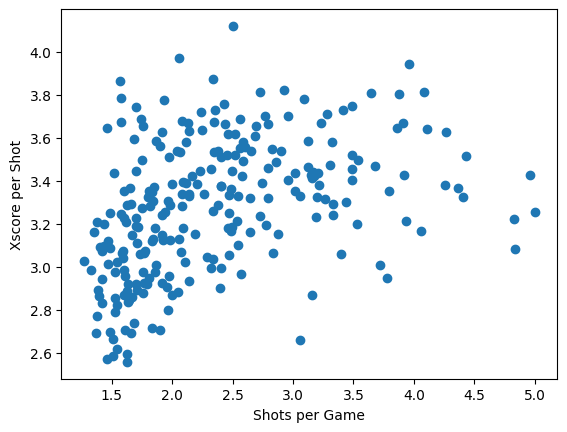

In [25]:
import matplotlib.pyplot as plt

plt.scatter(player_summary['shots_per_game'], player_summary['xscore_per_shot'])
plt.ylabel('Xscore per Shot')
plt.xlabel('Shots per Game')
plt.show()

Positions

In [52]:
player_position_summary = create_expected_score_summary(player_match_summary, group_cols=['Position_Group', 'Player'], min_games=10, min_shots=30)
forward_summary = player_position_summary.loc['Forward']
forward_summary.head(10)

,score,xscore,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc
Player,,,,,,,,,,,,,
Charlie Cameron,1402,1406.824470,386,100,84.171717,3.632124,14.020000,3.644623,14.068245,3.860000,14.990784,15.042369,4.127277
Joe Daniher,1367,1376.907439,410,94,92.322581,3.334146,14.542553,3.358311,14.647951,4.361702,14.176703,14.279450,4.251974
Jeremy Cameron,1445,1302.210879,401,80,92.612500,3.603491,18.062500,3.247409,16.277636,5.012500,17.552976,15.818461,4.871103
Toby Greene,1301,1259.339419,391,81,90.962963,3.327366,16.061728,3.220817,15.547400,4.827160,15.891694,15.382810,4.776059
Charlie Curnow,1357,1240.111365,362,73,91.273973,3.748619,18.589041,3.425722,16.987827,4.958904,18.329581,16.750716,4.889689
Harry McKay,1225,1229.764718,350,79,88.303797,3.500000,15.506329,3.513613,15.566642,4.430380,15.804186,15.865657,4.515482
Aaron Naughton,1130,1214.401772,321,84,83.202381,3.520249,13.452381,3.783183,14.457164,3.821429,14.551438,15.638312,4.133639
Tom Hawkins,1277,1179.728829,354,80,93.312500,3.607345,15.962500,3.332567,14.746610,4.425000,15.395847,14.223121,4.267917
Jesse Hogan,1177,1155.432652,293,74,85.797297,4.017065,15.905405,3.943456,15.613955,3.959459,16.684517,16.378790,4.153410


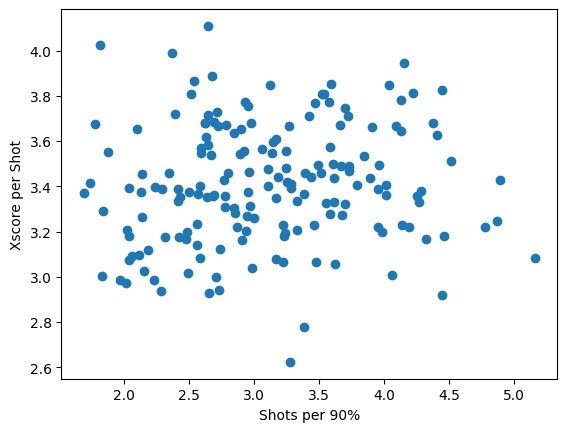

In [53]:
plt.scatter(forward_summary['shots_per_90pc'], forward_summary['xscore_per_shot'])
plt.ylabel('Xscore per Shot')
plt.xlabel('Shots per 90%')
plt.show()

In [50]:
midfield_summary = player_position_summary.loc['Midfield']
midfield_summary.sort_values(by = 'xscore', ascending = False).head(10)

,,score,xscore,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc
Player,Year,,,,,,,,,,,,,
Christian Petracca,2021,193,216.156111,71,23,89.260870,2.718310,8.391304,3.044452,9.398092,3.086957,8.460789,9.475913,3.112518
Chad Warner,2024,235,191.185655,61,22,81.761905,3.852459,10.681818,3.134191,8.690257,2.772727,11.758088,9.565862,3.052099
Dylan Moore,2024,161,185.533420,53,21,87.428571,3.037736,7.666667,3.500631,8.834925,2.523810,7.892157,9.094776,2.598039
Marcus Bontempelli,2024,207,176.978891,53,21,83.714286,3.905660,9.857143,3.339224,8.427566,2.523810,10.597270,9.060353,2.713311
Christian Petracca,2023,137,170.173038,59,17,82.529412,2.322034,8.058824,2.884289,10.010179,3.470588,8.788311,10.916303,3.784747
Isaac Heeney,2024,203,166.467686,53,21,82.400000,3.830189,9.666667,3.140900,7.927033,2.523810,10.558252,8.658167,2.756588
Zac Bailey,2021,145,140.924846,42,17,81.294118,3.452381,8.529412,3.355353,8.289697,2.470588,9.442836,9.177450,2.735166
Hugh McCluggage,2022,137,131.978205,42,21,81.809524,3.261905,6.523810,3.142338,6.284676,2.000000,7.176950,6.913876,2.200233
Patrick Cripps,2022,129,128.701647,38,17,80.117647,3.394737,7.588235,3.386885,7.570685,2.235294,8.524229,8.504514,2.511013


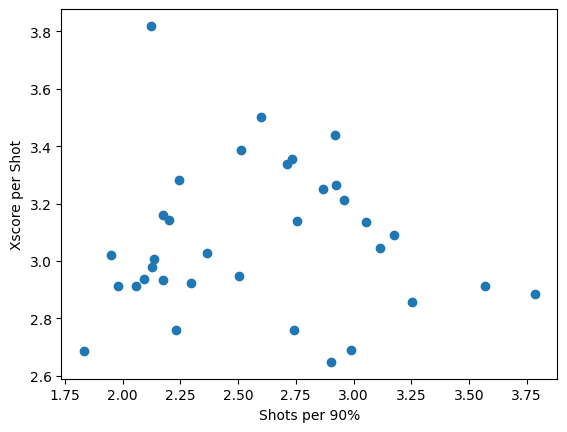

In [51]:
plt.scatter(midfield_summary['shots_per_90pc'], midfield_summary['xscore_per_shot'])
plt.ylabel('Xscore per Shot')
plt.xlabel('Shots per 90%')
plt.show()

Positions and Year

In [79]:
player_position_year_summary = create_expected_score_summary(player_match_summary, group_cols=['Position_Group','Year',  'Player'], min_shots = 10, min_games = 10)
player_position_year_summary.sort_values(by = 'xscore_per_90pc', ascending = False).head(10)

score      xscore  num_shots  num_games  \
Position_Group Year Player                                                    
Forward        2022 Tom Lynch         405  383.229288         99         19   
               2021 Harry McKay       394  386.423523        102         19   
               2023 Taylor Walker     496  401.560650        129         22   
               2024 Jesse Hogan       489  453.423835        116         25   
               2021 Toby Greene       317  330.157440        103         18   
               2022 Charlie Curnow    432  408.184814        117         22   
               2024 Ben King          363  371.270827         98         22   
               2022 Aaron Naughton    340  368.443104         97         22   
               2023 Jack Higgins      227  264.231440         75         17   
               2024 Charlie Curnow    383  359.233990        103         21   

                                    percent_played  score_per_shot  \
Position_Group Year Player                                           
Forward        2022 Tom Lynch            84.263158        4.090909   
               2021 Harry McKay          86.157895        3.862745   
               2023 Taylor Walker        82.863636        3.844961   
               2024 Jesse Hogan          87.600000        4.215517   
               2021 Toby Greene          90.388889        3.077670   
               2022 Charlie Curnow       91.909091        3.692308   
               2024 Ben King             84.318182        3.704082   
               2022 Aaron Naughton       85.909091        3.505155   
               2023 Jack Higgins         80.941176        3.026667   
               2024 Charlie Curnow       89.904762        3.718447   

                                    score_per_game  xscore_per_shot  \
Position_Group Year Player                                            
Forward        2022 Tom Lynch            21.315789         3.871003   
               2021 Harry McKay          20.736842         3.788466   
               2023 Taylor Walker        22.545455         3.112873   
               2024 Jesse Hogan          19.560000         3.908826   
               2021 Toby Greene          17.611111         3.205412   
               2022 Charlie Curnow       19.636364         3.488759   
               2024 Ben King             16.500000         3.788478   
               2022 Aaron Naughton       15.454545         3.798383   
               2023 Jack Higgins         13.352941         3.523086   
               2024 Charlie Curnow       18.238095         3.487709   

                                    xscore_per_game  shots_per_game  \
Position_Group Year Player                                            
Forward        2022 Tom Lynch             20.169963        5.210526   
               2021 Harry McKay           20.338080        5.368421   
               2023 Taylor Walker         18.252757        5.863636   
               2024 Jesse Hogan           18.136953        4.640000   
               2021 Toby Greene           18.342080        5.722222   
               2022 Charlie Curnow        18.553855        5.318182   
               2024 Ben King              16.875947        4.454545   
               2022 Aaron Naughton        16.747414        4.409091   
               2023 Jack Higgins          15.543026        4.411765   
               2024 Charlie Curnow        17.106380        4.904762   

                                    score_per_90pc  xscore_per_90pc  \
Position_Group Year Player                                            
Forward        2022 Tom Lynch            22.767021        21.543183   
               2021 Harry McKay          21.661576        21.245032   
               2023 Taylor Walker        24.487109        19.824717   
               2024 Jesse Hogan          20.095890        18.633856   
               2021 Toby Greene          17.535341        18.263165   
               2022 Charlie Curnow       19

In [80]:
player_position_year_summary.loc['Midfield'].sort_values(by = 'xscore_per_90pc', ascending = False).head(10)

score      xscore  num_shots  num_games  \
Year Player                                                         
2024 Ben Keays               94  121.204737         30         11   
2023 Christian Petracca     137  170.173038         59         17   
2021 Tarryn Thomas           96   96.178921         33         11   
2024 Cam Rayner             119  106.650264         31         12   
2023 Shai Bolton            126  123.611272         40         13   
2024 Chad Warner            235  191.185655         61         22   
     Jason Horne-Francis    109  120.841480         37         14   
2023 Zac Bailey             111  102.787035         32         12   
2021 Christian Petracca     193  216.156111         71         23   
     Nat Fyfe                57  100.768949         31         12   

                          percent_played  score_per_shot  score_per_game  \
Year Player                                                                
2024 Ben Keays                 86.454545        3.133333        8.545455   
2023 Christian Petracca        82.529412        2.322034        8.058824   
2021 Tarryn Thomas             75.636364        2.909091        8.727273   
2024 Cam Rayner                79.583333        3.838710        9.916667   
2023 Shai Bolton               87.230769        3.150000        9.692308   
2024 Chad Warner               81.761905        3.852459       10.681818   
     Jason Horne-Francis       81.357143        2.945946        7.785714   
2023 Zac Bailey                81.166667        3.468750        9.250000   
2021 Christian Petracca        89.260870        2.718310        8.391304   
     Nat Fyfe                  81.083333        1.838710        4.750000   

                          xscore_per_shot  xscore_per_game  shots_per_game  \
Year Player                                                                  
2024 Ben Keays                   4.040158        11.018612        2.727273   
2023 Christian Petracca          2.884289        10.010179        3.470588   
2021 Tarryn Thomas               2.914513         8.743538        3.000000   
2024 Cam Rayner                  3.440331         8.887522        2.583333   
2023 Shai Bolton                 3.090282         9.508559        3.076923   
2024 Chad Warner                 3.134191         8.690257        2.772727   
     Jason Horne-Francis         3.265986         8.631534        2.642857   
2023 Zac Bailey                  3.212095         8.565586        2.666667   
2021 Christian Petracca          3.044452         9.398092        3.086957   
     Nat Fyfe                    3.250611         8.397412        2.583333   

                          score_per_90pc  xscore_per_90pc  shots_per_90pc  
Year Player                                                                
2024 Ben Keays                  8.895899        11.470480        2.839117  
2023 Christian Petracca         8.788311        10.916303        3.784747  
2021 Tarryn Thomas             10.384615        10.403970        3.569712  
2024 Cam Rayner                11.214660        10.050810        2.921466  
2023 Shai Bolton               10.000000         9.810418        3.174603  
2024 Chad Warner               11.758088         9.565862        3.052099  
     Jason Horne-Francis        8.612818         9.548493        2.923617  
2023 Zac Bailey                10.256674         9.497775        2.956879  
2021 Christian Petracca         8.460789         9.475913        3.112518  
     Nat Fyfe                   5.272354         9.320869        2.867420

Diamond Scatter Plot

In [130]:
def get_diamond_plot_extents(data, x, y, x_pad, y_pad):
    
    extent_dict = {}
    extent_dict['x_mean'] = data[x].mean()
    extent_dict['y_mean'] = data[y].mean()
    extent_dict['x_max'] = data[x].max()
    extent_dict['y_max'] = data[y].max()
    extent_dict['x_min'] = data[x].min()
    extent_dict['y_min'] = data[y].min()

    extent_dict['x_extent_min'] = max(round_decimals_down(extent_dict['x_mean']-x_pad, 2), 0)
    extent_dict['x_extent_max'] = round_decimals_down(extent_dict['x_mean']+x_pad, 2)
    extent_dict['y_extent_min'] = max(round_decimals_down(extent_dict['y_mean']-y_pad, 2), 0)
    extent_dict['y_extent_max'] = round_decimals_down(extent_dict['y_mean']+y_pad, 2)
    
    return extent_dict

In [217]:
def plot_player_diamond_scatter_plot(data, x, y, x_pad, y_pad, nticks = 8, share_extent = False, annotate=False):
    
    extent_dict = get_diamond_plot_extents(data, x, y, x_pad, y_pad)
    
    if share_extent:
        extent_dict['y_extent_min'] = extent_dict['x_extent_min']
        extent_dict['y_extent_max'] = extent_dict['x_extent_max']
    
    fig = plt.figure(dpi=300)
    # fig.set_facecolor('#111111')
    plot_extents = extent_dict['x_extent_min'], extent_dict['x_extent_max'], extent_dict['y_extent_min'], extent_dict['y_extent_max']
    scaler = (extent_dict['y_extent_max'] - extent_dict['y_extent_min']) / (extent_dict['x_extent_max'] - extent_dict['x_extent_min']) 
    transform = Affine2D().scale(scaler, 1).rotate_deg(45)
    helper = floating_axes.GridHelperCurveLinear(transform, plot_extents,
                                                grid_locator1=MaxNLocator(nbins=nticks),
                                                grid_locator2=MaxNLocator(nbins=nticks)
                                                )
    
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)
    fig.add_subplot(ax)
    # ax.set_facecolor('#111111')
    # ax.axis[:].line.set_color("#FFFFFF")
    # ax.axis[:].label.set_color("#FFFFFF")
    # ax.axis[:].major_ticks.set_color("#FFFFFF")
    ax.axis[:].major_ticklabels.set(fontsize=6)
    ax.axis[:].label.set(fontsize=6)
    
    # ax.axis['left'].major_ticklabels.set_visible(False)
    # ax.axis['left'].label.set_visible(False)
    ax.axis['left'].label.set_axis_direction('bottom')

    # ax.axis['bottom'].major_ticklabels.set_visible(False)
    # ax.axis['bottom'].label.set_visible(False)
    ax.axis['bottom'].label.set_axis_direction('bottom')
    
    # ax.axis['right'].major_ticklabels.set_visible(True)
    # ax.axis['right'].label.set_visible(True)
    # ax.axis['right'].label.set_axis_direction("top")
    # ax.axis['right'].major_ticklabels.set_axis_direction("top")

    # ax.axis['top'].major_ticklabels.set_visible(True)
    # ax.axis['top'].label.set_visible(True)
    # ax.axis['top'].set_axis_direction("top")
    # ax.axis['top'].major_ticklabels.set_axis_direction("top")
    # ax.axis['top'].label.set_axis_direction("left")

    # ax.grid(visible=True, lw=0.2, ls=":", color="lightgrey")

    aux_ax = ax.get_aux_axes(transform)
    aux_ax.scatter(data[x], data[y], alpha=0.9, zorder=3, ec="w", lw=0.2)

    if annotate:
        text = list()
        data['sort'] = (data[x+"Norm"] + data[y+"Norm"]) / 2
        data_top5 = list(data.sort_values(by="sort", ascending=False).head(10).index)
        for i, name in enumerate(data_top5):
            text.append(aux_ax.annotate(name, (data.loc[name][x], data.loc[name][y]), size=4, zorder=3))
            
        adjustText.adjust_text(text, ax=ax)

    # Quadrants
    aux_ax.vlines(x=extent_dict['x_mean'], ymin=extent_dict['y_extent_min'], ymax=extent_dict['y_extent_max'], lw=0.5, ls="--")
    aux_ax.hlines(y=extent_dict['y_mean'], xmin=extent_dict['x_extent_min'], xmax=extent_dict['x_extent_max'], lw=0.5, ls="--")

    return fig, ax

In [218]:

def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

def round_decimals_down(number:float, decimals:int=2):
    """
    Returns a value rounded down to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor

In [219]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
# import adjustText

(0.0, 7.0)

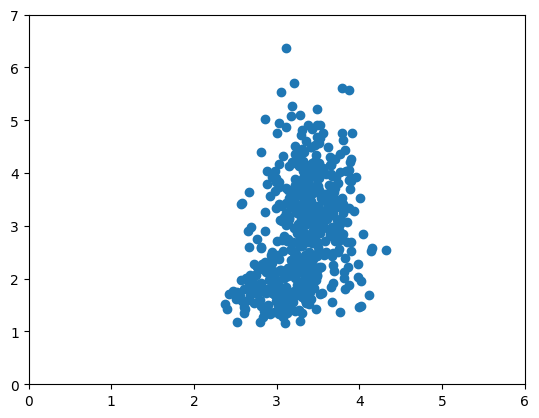

In [220]:
plt.scatter(data=player_position_year_summary, x='xscore_per_shot', y='shots_per_90pc')
plt.xlim(0, 6)
plt.ylim(0, 7)

Text(0, 0.5, 'shots_per_90pc')

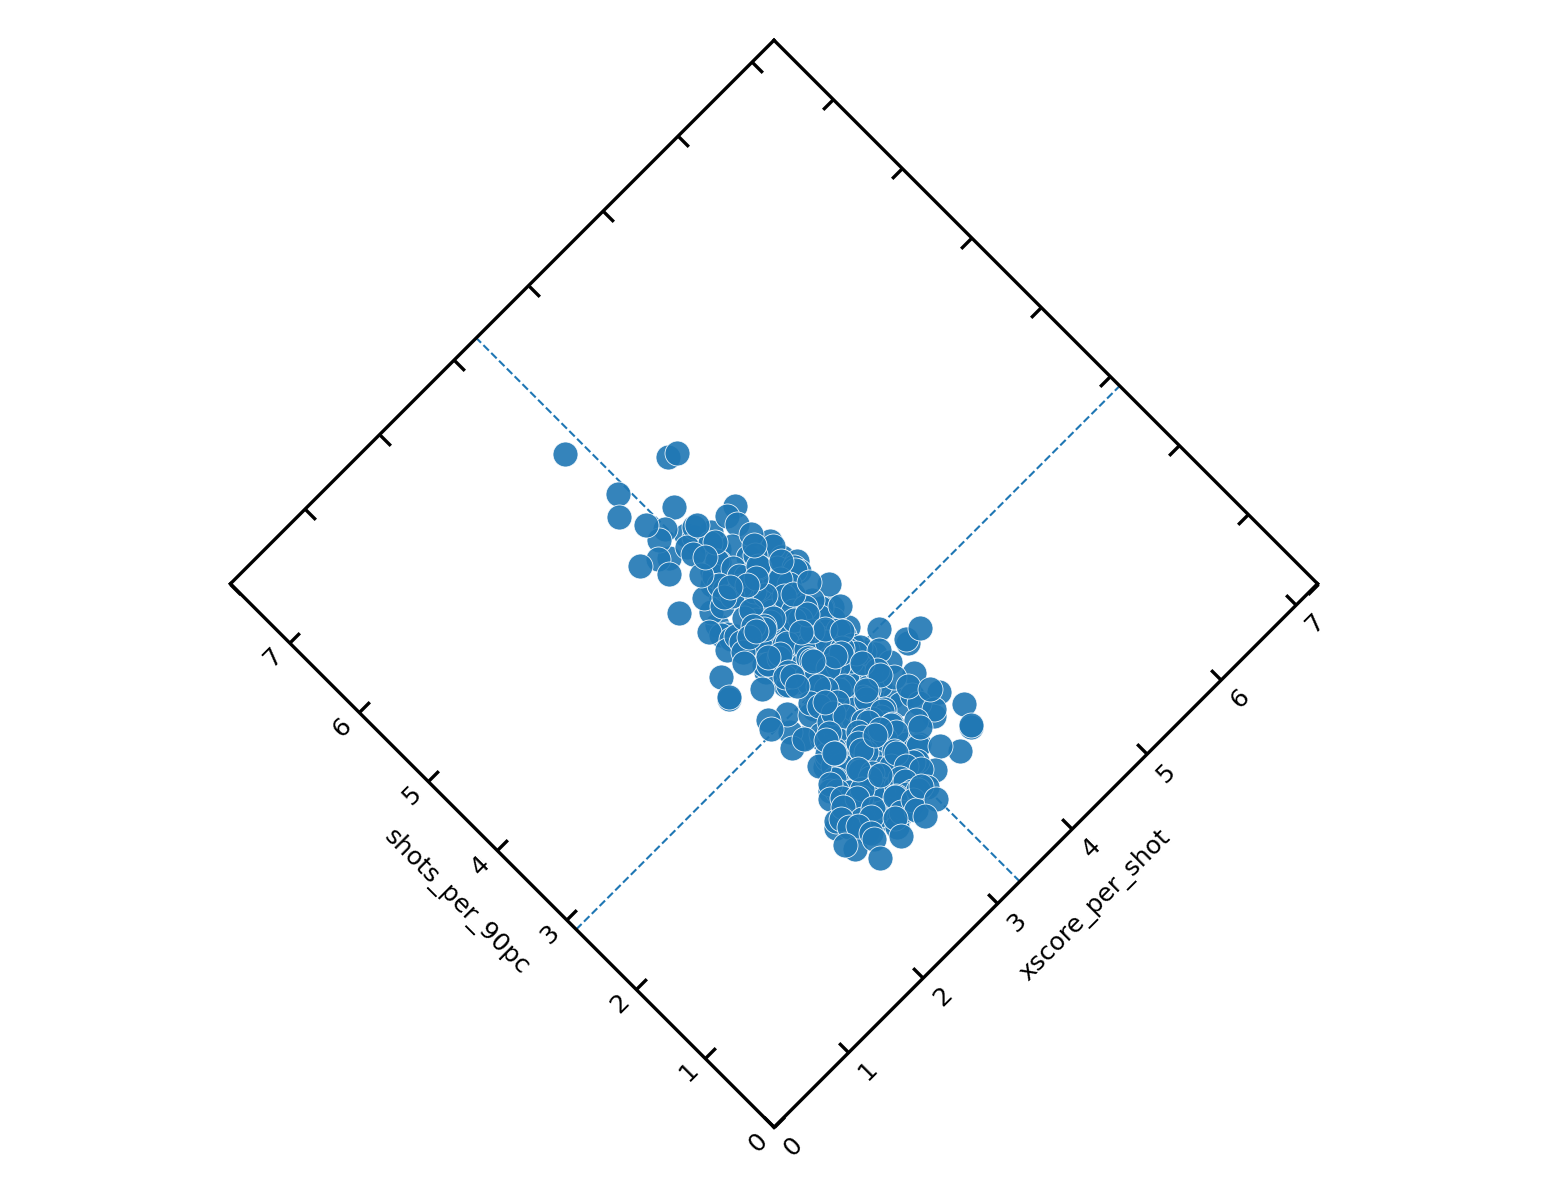

In [221]:
fig, ax = plot_player_diamond_scatter_plot(player_position_year_summary, x='xscore_per_shot', y='shots_per_90pc', x_pad=4, y_pad=5)
ax.set_xlabel('xscore_per_shot')
ax.set_ylabel('shots_per_90pc')

Raincloud Plot

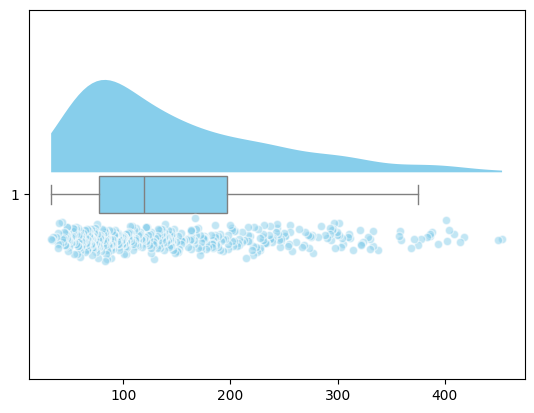

In [129]:
fig, ax = plt.subplots()

cloud = ax.violinplot(player_position_year_summary['xscore'], [1.06], showmeans=False, showextrema=False, side='high', orientation='horizontal')
for pc in cloud['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_alpha(1)

# Create the box plot
c = 'grey'
box = ax.boxplot(player_position_year_summary['xscore'], vert=False, widths=0.1, patch_artist=True, showfliers=False,
            boxprops=dict(facecolor='skyblue', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color='', markeredgecolor=c),
            medianprops=dict(color=c),
)
y = np.random.normal(1-0.12, 0.02, size=len(player_position_year_summary['xscore']))
ax.scatter(player_position_year_summary['xscore'], y, alpha=0.5, color='skyblue', zorder=2, edgecolors='white')
# ax = sns.swarmplot(x='xscore', data=player_position_year_summary, color="grey", ax=ax)
